In [10]:
from cross_loss_influence.models.skip_gram_word2vec import SkipGramModel
import numpy as np
from cross_loss_influence.config import PROJECT_HOME, DATA_DIR, MODEL_SAVE_DIR, PROJECT_NAME
import torch
import os
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA
import copy
from sklearn.neighbors import KDTree
from sklearn.manifold import TSNE

In [2]:
most_recent_model = torch.load(os.path.join(MODEL_SAVE_DIR, 
                                            PROJECT_NAME,
                                            'checkpoints', 
                                            'medkd_window-8_negatives-20_last_checkpoint.pth.tar'),
                               map_location='cpu')

In [3]:
stoi = pickle.load(open(os.path.join(DATA_DIR, 'stoi.pkl'), 'rb'))

In [4]:
model = SkipGramModel(vocab_size=475000, embedding_dim=300).to(device='cpu')
model.load_state_dict(most_recent_model['model_data'])


<All keys matched successfully>

In [5]:
all_keys = []
all_values = []
for key, val in stoi.items():
    all_keys.append(key)
    all_values.append(val)

In [6]:
embeddings = model.u_embeddings

In [15]:
cluster_data = embeddings(torch.tensor(all_values)).detach().numpy()[:1000]
plot_data = copy.deepcopy(cluster_data)
print(f"All told we have {cluster_data.shape[0]} embeddings")

All told we have 1000 embeddings


In [16]:
tree = KDTree(cluster_data)

For n_clusters = 2 The average silhouette_score is : 0.027277235
Cluster 0 nearest neighbors are: ['<MASK>', '<SOS>', '<NUM>', '<PAD>', '<EOS>']
Cluster 1 nearest neighbors are: ['<SOS>', '<MASK>', '<NUM>', '<EOS>', '<PAD>']
For n_clusters = 3 The average silhouette_score is : 0.012085985
Cluster 0 nearest neighbors are: ['<MASK>', '<NUM>', '<SOS>', '<PAD>', '<EOS>']
Cluster 1 nearest neighbors are: ['<MASK>', '<SOS>', '<NUM>', '<EOS>', '<PAD>']
Cluster 2 nearest neighbors are: ['<UNK>', '<SOS>', '<NUM>', '<EOS>', '<MASK>']
For n_clusters = 4 The average silhouette_score is : 0.011275055
Cluster 0 nearest neighbors are: ['<MASK>', '<NUM>', '<SOS>', '<PAD>', '<EOS>']
Cluster 1 nearest neighbors are: ['<SOS>', '<NUM>', '<MASK>', '<EOS>', '<PAD>']
Cluster 2 nearest neighbors are: ['<UNK>', '<SOS>', '<NUM>', '<EOS>', '<MASK>']
Cluster 3 nearest neighbors are: ['<MASK>', '<EOS>', '<SOS>', '<NUM>', '<PAD>']
For n_clusters = 5 The average silhouette_score is : 0.0056285146
Cluster 0 nearest n

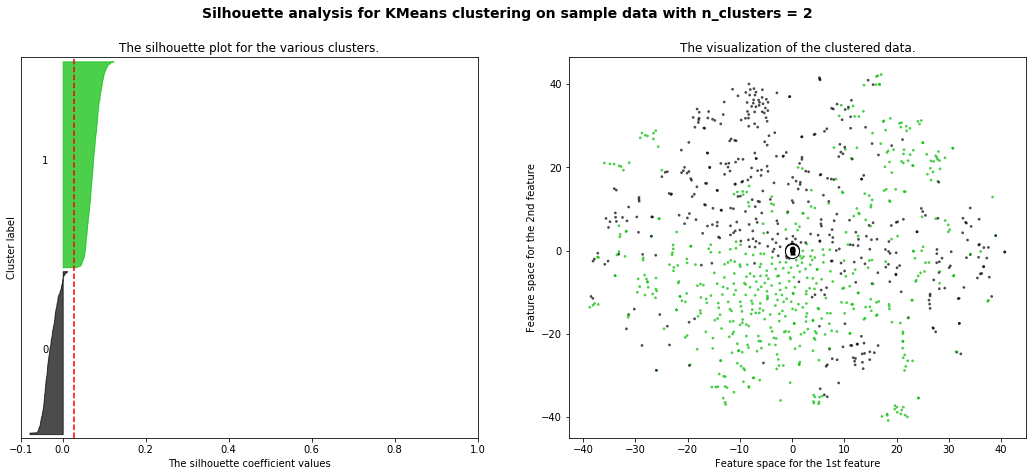

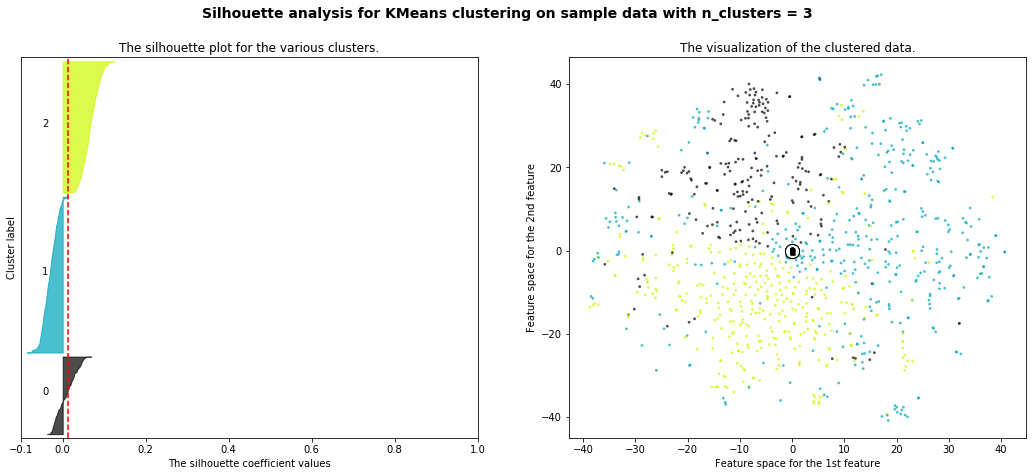

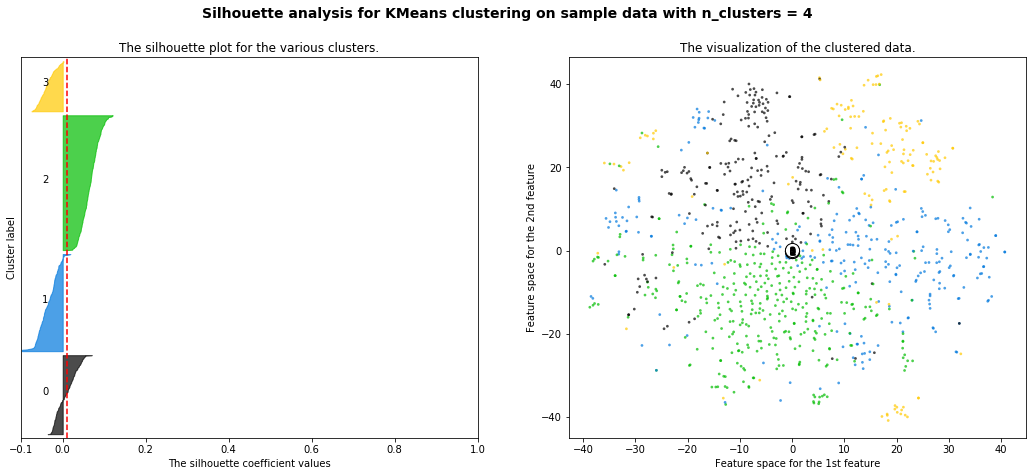

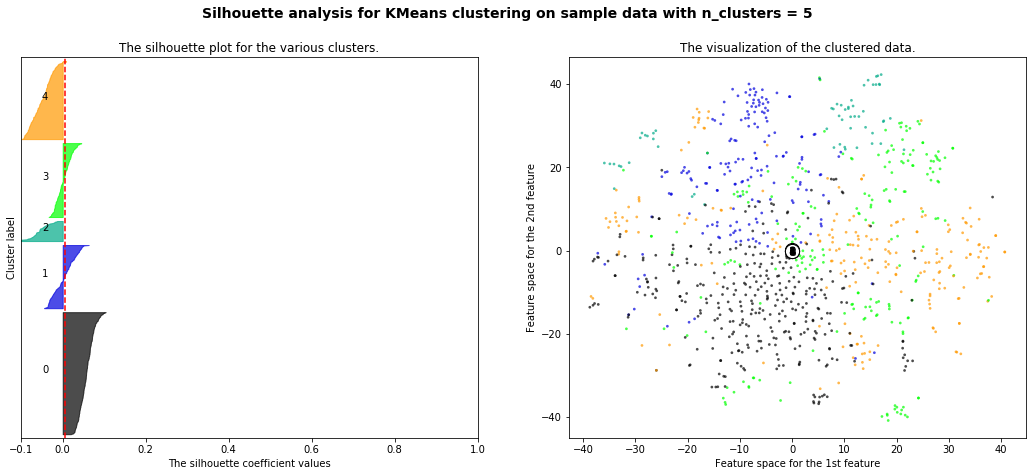

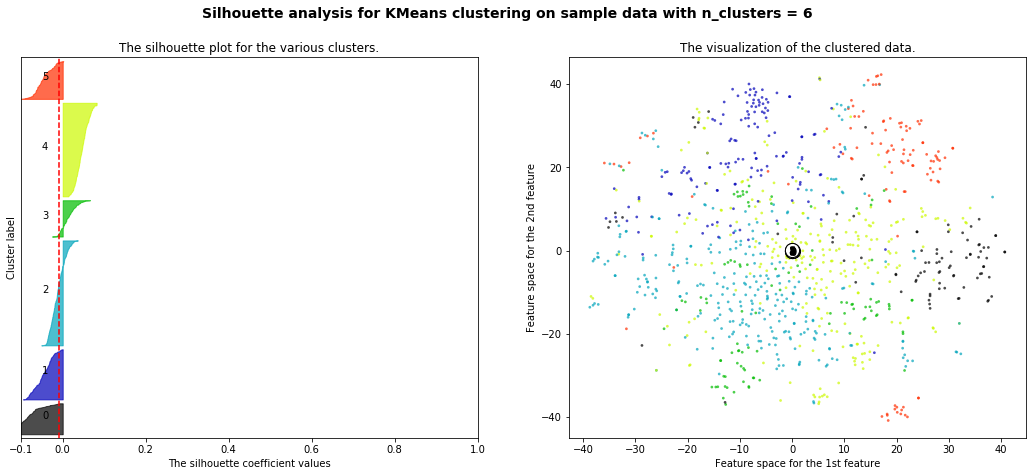

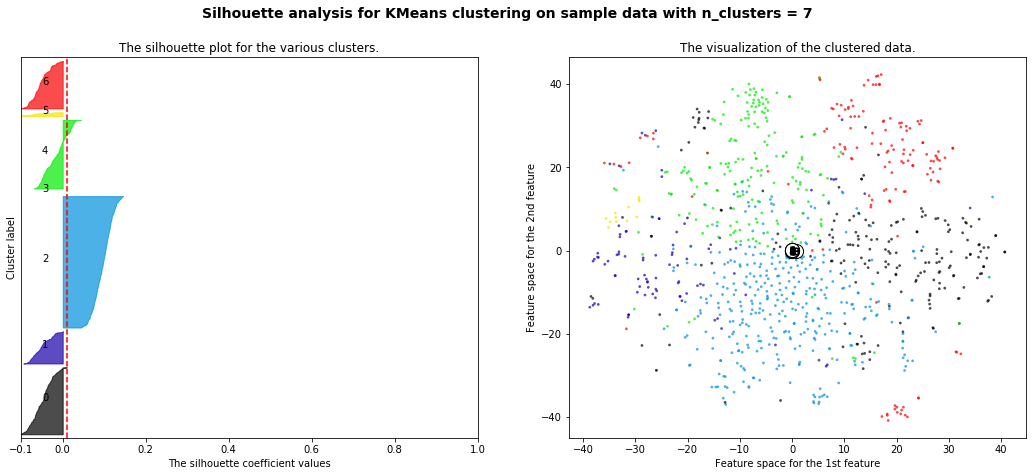

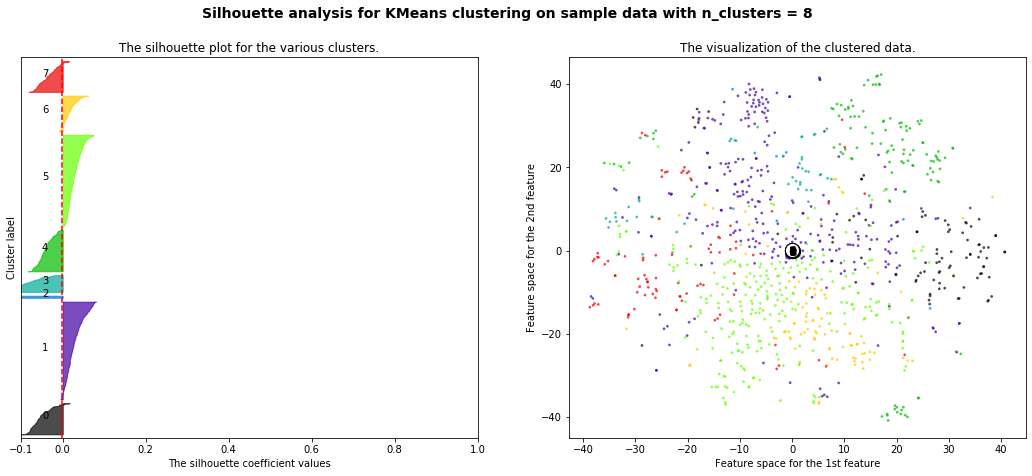

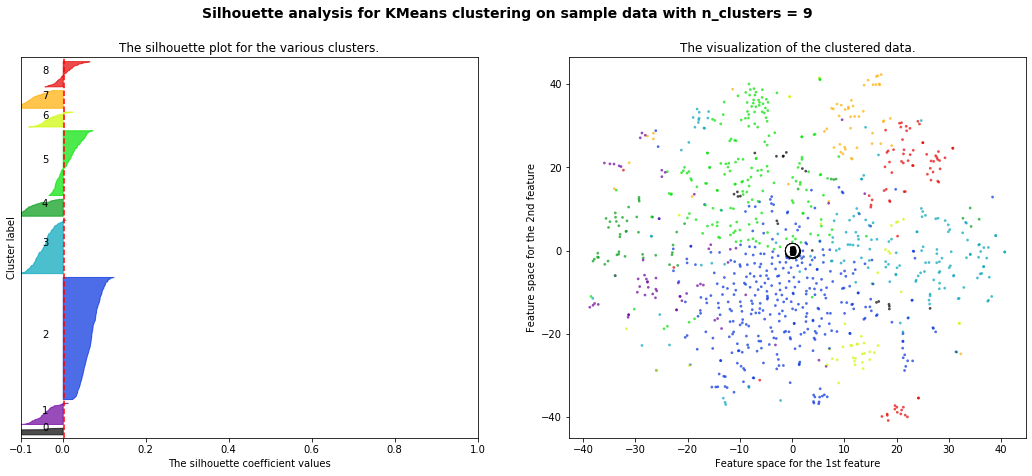

In [18]:
range_n_clusters = range(2, 10)
pca = PCA(n_components=50, svd_solver='full')
plot_data = pca.fit_transform(plot_data)
plot_data = TSNE(n_components=2).fit_transform(plot_data)
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(plot_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clf = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clf.fit_predict(cluster_data)
    centroids = clf.cluster_centers_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(cluster_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(cluster_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(plot_data[:, 0], plot_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clf.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        dist, ind = tree.query([c], k=5)
        print(f"Cluster {i} nearest neighbors are: {[all_keys[word_ind] for word_ind in ind[0]]}")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()